In [1]:
import os
import pandas as pd
import torch
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

from torch.autograd import Variable

#Neural Network

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import copy
import argparse

#Ignore Warning

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Hyper parameters
num_epochs = 25
num_classes = 5
batch_size = 100
learning_rate = 0.001


In [3]:
def load_dataset():
    data_dir = 'data/'
    
    data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
    
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
    
    
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
                  for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    
    class_names = image_datasets['train'].classes
    
    
    return dataloaders, class_names
    
    

In [4]:
dataloaders,class_names = load_dataset()

train_iter = iter(dataloaders)
print(type(train_iter))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

<class 'dict_keyiterator'>
cuda:0


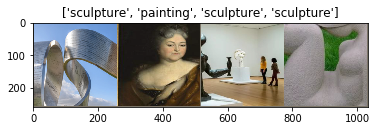

In [6]:
#Function to visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
dataloaders, class_names = load_dataset()
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
"""
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            dataloaders, class_names, dataset_sizes = load_dataset()
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
"""

"\ndef train_model(model, criterion, optimizer, scheduler, num_epochs=25):\n    since = time.time()\n\n    best_model_wts = copy.deepcopy(model.state_dict())\n    best_acc = 0.0\n\n    for epoch in range(num_epochs):\n        print('Epoch {}/{}'.format(epoch, num_epochs - 1))\n        print('-' * 10)\n\n        # Each epoch has a training and validation phase\n        for phase in ['train', 'val']:\n            if phase == 'train':\n                scheduler.step()\n                model.train()  # Set model to training mode\n            else:\n                model.eval()   # Set model to evaluate mode\n\n            running_loss = 0.0\n            running_corrects = 0\n\n            # Iterate over data.\n            dataloaders, class_names, dataset_sizes = load_dataset()\n            for inputs, labels in dataloaders[phase]:\n                inputs = inputs.to(device)\n                labels = labels.to(device)\n\n                # zero the parameter gradients\n                optim

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    dataloaders, class_names, dataset_sizes = load_dataset()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
# Custom Model 

class TwoLayerNet(torch.nn.Module):
    def __init__(self, num_classes = 5):
        
        super(TwoLayerNet, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3,64,5,1,2),
        nn.BatchNorm2d(64),    
        nn.ReLU(True),
        nn.MaxPool2d(5,2,2),
        
        nn.Conv2d(64,64,5,1,2),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.MaxPool2d(5,1,2)
        
        )
        #O/p 128*128*64

          
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,5,1,2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(5,2,2),
            
            nn.Conv2d(128,128,5,1,2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(5,1,2)
        )
        #O/p : 64*64*128
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128,256,5,1,2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(5,2,2),
            
            nn.Conv2d(256,256,5,1,2),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(5,1,2)
        )
        #O/p : 32*32*256
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256,512,5,1,2),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(5,2,2),
            
            nn.Conv2d(512,512,5,1,2),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(5,1,2)
        )
        
        
        #O/p : 16*16*512 
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512,512,5,1,2),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(5,2,2),
            
            nn.Conv2d(512,512,5,1,2),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(5,1,2)
        )
        
        #O/p : 8*8*512
        
        self.fc1 = nn.Linear(8*8*512, num_classes)
        #nn.ReLU(True)
        #self.fc2 = nn.Linear(4096, 4096)
        #nn.ReLU(True)
        #self.fc3 = nn.Linear(4096, num_classes)
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out


In [12]:
model = TwoLayerNet(5).to(device)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Train the model
total_step = len(dataloaders['train'])
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/25], Step [100/1931], Loss: 1.3625
Epoch [1/25], Step [200/1931], Loss: 3.3454
Epoch [1/25], Step [300/1931], Loss: 0.9653
Epoch [1/25], Step [400/1931], Loss: 1.6003
Epoch [1/25], Step [500/1931], Loss: 1.2530
Epoch [1/25], Step [600/1931], Loss: 1.7304
Epoch [1/25], Step [700/1931], Loss: 1.4841
Epoch [1/25], Step [800/1931], Loss: 1.6840
Epoch [1/25], Step [900/1931], Loss: 0.9888
Epoch [1/25], Step [1000/1931], Loss: 1.5849
Epoch [1/25], Step [1100/1931], Loss: 1.2320
Epoch [1/25], Step [1200/1931], Loss: 1.0996
Epoch [1/25], Step [1300/1931], Loss: 1.0917
Epoch [1/25], Step [1400/1931], Loss: 0.9301
Epoch [1/25], Step [1500/1931], Loss: 1.0501
Epoch [1/25], Step [1600/1931], Loss: 1.2008
Epoch [1/25], Step [1700/1931], Loss: 1.3684
Epoch [1/25], Step [1800/1931], Loss: 1.1441
Epoch [1/25], Step [1900/1931], Loss: 0.7397
Epoch [2/25], Step [100/1931], Loss: 1.4693
Epoch [2/25], Step [200/1931], Loss: 2.2005
Epoch [2/25], Step [300/1931], Loss: 0.7733
Epoch [2/25], Step [40

Epoch [10/25], Step [1400/1931], Loss: 0.1765
Epoch [10/25], Step [1500/1931], Loss: 0.4538
Epoch [10/25], Step [1600/1931], Loss: 1.5166
Epoch [10/25], Step [1700/1931], Loss: 0.0991
Epoch [10/25], Step [1800/1931], Loss: 0.3896
Epoch [10/25], Step [1900/1931], Loss: 0.9543
Epoch [11/25], Step [100/1931], Loss: 0.9048
Epoch [11/25], Step [200/1931], Loss: 0.3928
Epoch [11/25], Step [300/1931], Loss: 0.6867
Epoch [11/25], Step [400/1931], Loss: 0.4672
Epoch [11/25], Step [500/1931], Loss: 0.3151
Epoch [11/25], Step [600/1931], Loss: 0.9648
Epoch [11/25], Step [700/1931], Loss: 0.2110
Epoch [11/25], Step [800/1931], Loss: 0.6149
Epoch [11/25], Step [900/1931], Loss: 0.8397
Epoch [11/25], Step [1000/1931], Loss: 0.2883
Epoch [11/25], Step [1100/1931], Loss: 0.6106
Epoch [11/25], Step [1200/1931], Loss: 1.5020
Epoch [11/25], Step [1300/1931], Loss: 1.4370
Epoch [11/25], Step [1400/1931], Loss: 1.2504
Epoch [11/25], Step [1500/1931], Loss: 0.2925
Epoch [11/25], Step [1600/1931], Loss: 0.94

Epoch [20/25], Step [400/1931], Loss: 1.4190
Epoch [20/25], Step [500/1931], Loss: 2.2988
Epoch [20/25], Step [600/1931], Loss: 0.1432
Epoch [20/25], Step [700/1931], Loss: 1.0919
Epoch [20/25], Step [800/1931], Loss: 0.1620
Epoch [20/25], Step [900/1931], Loss: 0.5777
Epoch [20/25], Step [1000/1931], Loss: 0.7236
Epoch [20/25], Step [1100/1931], Loss: 0.1662
Epoch [20/25], Step [1200/1931], Loss: 0.2370
Epoch [20/25], Step [1300/1931], Loss: 1.2966
Epoch [20/25], Step [1400/1931], Loss: 0.0496
Epoch [20/25], Step [1500/1931], Loss: 1.0639
Epoch [20/25], Step [1600/1931], Loss: 0.9410
Epoch [20/25], Step [1700/1931], Loss: 0.6890
Epoch [20/25], Step [1800/1931], Loss: 0.7321
Epoch [20/25], Step [1900/1931], Loss: 0.7450
Epoch [21/25], Step [100/1931], Loss: 0.6973
Epoch [21/25], Step [200/1931], Loss: 0.6133
Epoch [21/25], Step [300/1931], Loss: 1.4746
Epoch [21/25], Step [400/1931], Loss: 0.1190
Epoch [21/25], Step [500/1931], Loss: 0.5949
Epoch [21/25], Step [600/1931], Loss: 0.4099


In [16]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model : {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model : 85.51401869158879 %
